# Multi-step forecasts

Two modeling strategies for multi-step forecasting

- Recursively forecasting the future n periods with one model
- Directly forecasting each of the future n periods with n models

## Installation
- sktime
- lightgbm

In [ ]:
!pip install sktime
!pip install lightgbm

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
path = '/content/gdrive/My Drive/data/time_series'
data = pd.read_csv(path + '/electric_consumption.csv', index_col='Date')
data.index = pd.to_datetime(data.index)
data = data.sort_index() # Make sure the data are sorted
data.index = pd.PeriodIndex(data.index, freq='H') # Make sure the Index is sktime format
data.index

PeriodIndex(['2017-12-11 00:00', '2017-12-11 01:00', '2017-12-11 02:00',
             '2017-12-11 03:00', '2017-12-11 04:00', '2017-12-11 05:00',
             '2017-12-11 06:00', '2017-12-11 07:00', '2017-12-11 08:00',
             '2017-12-11 09:00',
             ...
             '2020-06-25 08:00', '2020-06-25 09:00', '2020-06-25 10:00',
             '2020-06-25 11:00', '2020-06-25 12:00', '2020-06-25 13:00',
             '2020-06-25 14:00', '2020-06-25 15:00', '2020-06-25 16:00',
             '2020-06-25 17:00'],
            dtype='period[H]', name='Date', length=22201)

In [5]:
y = data['Consumption']
y

Date
2017-12-11 00:00     56
2017-12-11 01:00     56
2017-12-11 02:00     55
2017-12-11 03:00     52
2017-12-11 04:00     46
                   ... 
2020-06-25 13:00     73
2020-06-25 14:00     82
2020-06-25 15:00     74
2020-06-25 16:00     99
2020-06-25 17:00    103
Freq: H, Name: Consumption, Length: 22201, dtype: int64

In [ ]:
cuttime = int(len(y)*0.9) # Take 90% for training
train = y[0:cuttime]
test = y[cuttime::]
test

Date
2020-03-25 05:00     52
2020-03-25 06:00     47
2020-03-25 07:00     44
2020-03-25 08:00     42
2020-03-25 09:00     41
                   ... 
2020-06-25 13:00     73
2020-06-25 14:00     82
2020-06-25 15:00     74
2020-06-25 16:00     99
2020-06-25 17:00    103
Freq: H, Name: Consumption, Length: 2221, dtype: int64

## (1) Recursively forecasting the future n periods with one model: sktime

### GBM

In [ ]:
from sktime.forecasting.compose import make_reduction
from sklearn.ensemble import GradientBoostingRegressor
gbm_regressor = GradientBoostingRegressor()
gbm_forecaster = make_reduction(gbm_regressor, window_length=30, strategy="recursive")
gbm_forecaster.fit(train)

RecursiveTabularRegressionForecaster(estimator=GradientBoostingRegressor(),
                                     window_length=30)

In [ ]:
len(list(range(1, len(test)+1,1)))

2221

In [ ]:
vlen = 600
y_test_pred = gbm_forecaster.predict(fh=list(range(1, vlen,1)))
y_test_pred

2020-03-25 05:00    52.290698
2020-03-25 06:00    46.840137
2020-03-25 07:00    43.287588
2020-03-25 08:00    40.912258
2020-03-25 09:00    40.361486
                      ...    
2020-04-18 23:00    85.009296
2020-04-19 00:00    83.091387
2020-04-19 01:00    79.518339
2020-04-19 02:00    74.506086
2020-04-19 03:00    67.886682
Freq: H, Name: Consumption, Length: 599, dtype: float64

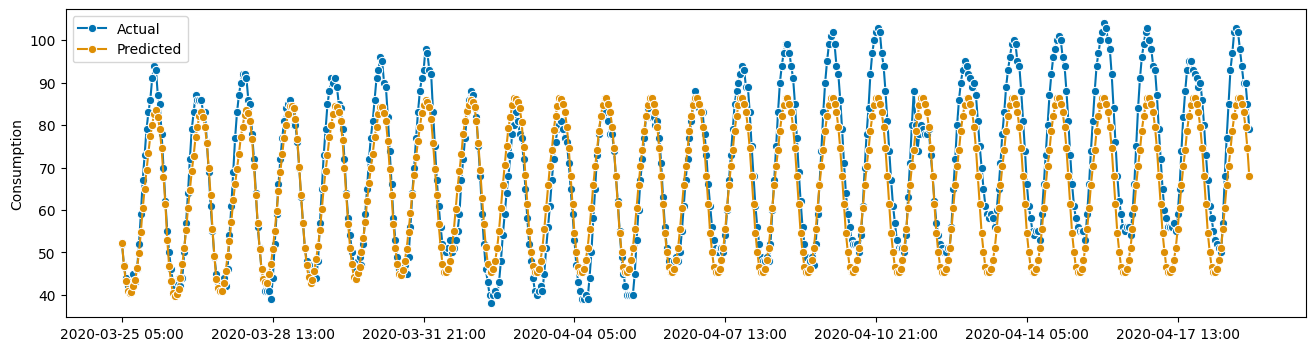

In [ ]:
actual = test[test.index<=y_test_pred.index.max()]
plot_series(actual, y_test_pred, labels=['Actual', 'Predicted'])
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(actual, y_test_pred)

0.09339982449579282

### LightGBM

In [ ]:
import lightgbm as lgb
lgb_regressor = lgb.LGBMRegressor(num_leaves = 10,
              learning_rate = 0.02,
              feature_fraction = 0.8,
              max_depth = 5,
              verbose = 0,
              num_boost_round = 15000,
              nthread = -1
)
lgb_forecaster = make_reduction(lgb_regressor, window_length=30, strategy="recursive")
lgb_forecaster.fit(train)

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] num_iterations is set=15000, num_boost_round=15000 will be ignored. Current value: num_iterations=15000
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

RecursiveTabularRegressionForecaster(estimator=LGBMRegressor(feature_fraction=0.8, learning_rate=0.02, max_depth=5, nthread=-1,
              num_boost_round=15000, num_leaves=10, verbose=0),
                                     window_length=30)

In [ ]:
vlen = 100
y_test_pred = lgb_forecaster.predict(fh=list(range(1, vlen,1)))
y_test_pred

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGB

2020-03-25 05:00    52.774866
2020-03-25 06:00    47.493968
2020-03-25 07:00    42.992413
2020-03-25 08:00    40.438201
2020-03-25 09:00    39.628962
                      ...    
2020-03-29 03:00    67.045141
2020-03-29 04:00    60.130457
2020-03-29 05:00    53.589149
2020-03-29 06:00    49.204090
2020-03-29 07:00    45.570110
Freq: H, Name: Consumption, Length: 99, dtype: float64

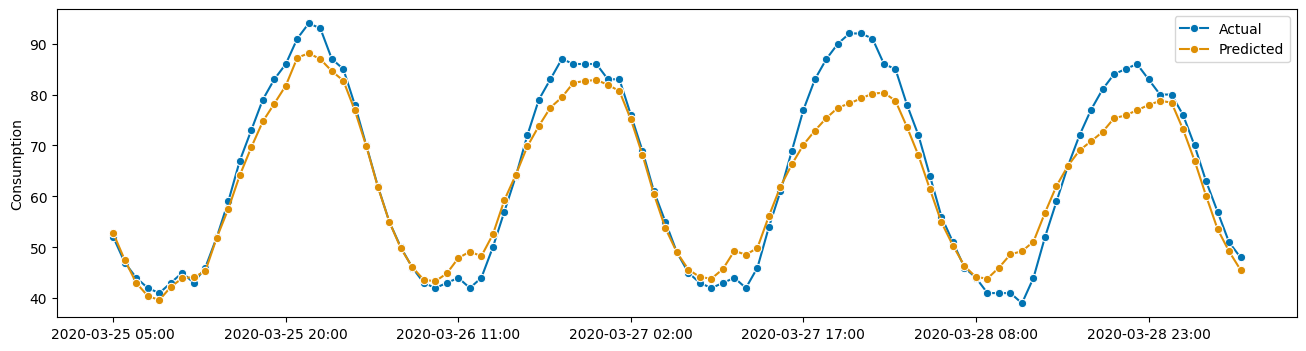

In [ ]:
actual = test[test.index<=y_test_pred.index.max()]
plot_series(actual, y_test_pred, labels=['Actual', 'Predicted'])
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(actual, y_test_pred)

0.05463824931156526

### Evaluation metric: Mean absolute percentage error (MAPE) vs. symmetric MAPE

- The default is symmetric = False
- The best value is 0.0. Both MAPE and sMAPE output is non-negative floating point.
- sMAPE is measured in absolute percentage error relative to the actual values in the test data. Because it takes the absolute value rather than square the percentage forecast error, it penalizes large errors less than MSPE, RMSPE, MdSPE or RMdSPE.

In [ ]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
print('%.16f' % mean_absolute_percentage_error(actual, y_test_pred, symmetric=False))

0.0546382493115653


In [ ]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
print('%.16f' % mean_absolute_percentage_error(actual, y_test_pred, symmetric=True))

0.0547477326419614


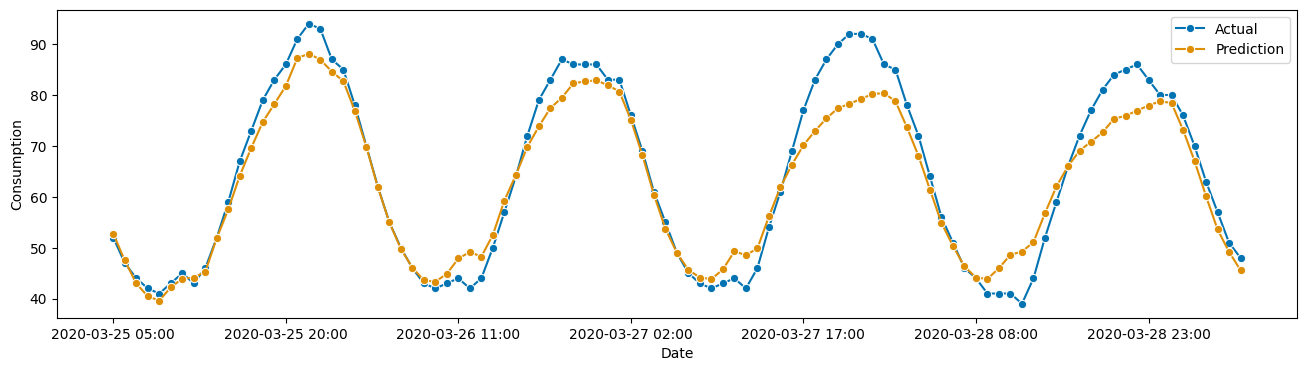

In [ ]:
from sktime.utils.plotting import plot_series
plot_series(actual, y_test_pred, labels=["Actual", "Prediction"], x_label='Date', y_label='Consumption');

## (2) Directly forecasting each of the future n periods with n models

In [ ]:
from sktime.forecasting.compose import make_reduction
import lightgbm as lgb
lgb_regressor = lgb.LGBMRegressor(num_leaves = 10,
              learning_rate = 0.02,
              feature_fraction = 0.8,
              max_depth = 5,
              verbose = 0,
              num_boost_round = 15000,
              nthread = -1
)
lgb_forecaster = make_reduction(lgb_regressor, window_length=30, strategy="direct")

In [ ]:
vlen = 100
fh=list(range(1, vlen,1))
lgb_forecaster.fit(train, fh = fh)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
y_test_pred = lgb_forecaster.predict(fh=fh)
y_test_pred

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGB

2020-03-25 05:00    53.208883
2020-03-25 06:00    48.056281
2020-03-25 07:00    43.779540
2020-03-25 08:00    42.671936
2020-03-25 09:00    42.771670
                      ...    
2020-03-29 03:00    67.735008
2020-03-29 04:00    61.742973
2020-03-29 05:00    52.974728
2020-03-29 06:00    48.179975
2020-03-29 07:00    43.164925
Freq: H, Name: Consumption, Length: 99, dtype: float64

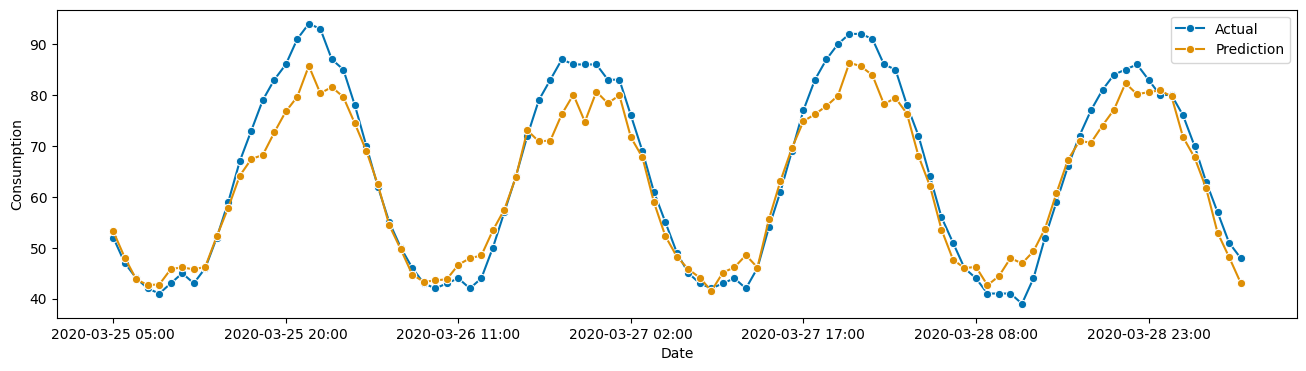

In [ ]:
from sktime.utils.plotting import plot_series
plot_series(actual, y_test_pred, labels=["Actual", "Prediction"], x_label='Date', y_label='Consumption');

In [ ]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
print('%.16f' % mean_absolute_percentage_error(actual, y_test_pred, symmetric=False))

0.0556899099509884


In [ ]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
print('%.16f' % mean_absolute_percentage_error(actual, y_test_pred, symmetric=True))

0.0564747643400997


### ARIMA

In [6]:
!pip install pmdarima

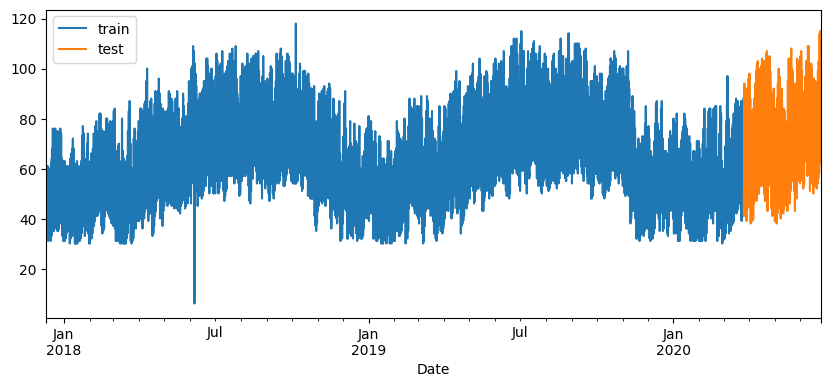

In [7]:
from sktime.forecasting.model_selection import temporal_train_test_split
train, test = temporal_train_test_split(y, train_size = 0.9)

fig, ax = plt.subplots(1,1, figsize=(10, 4))
train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test')
plt.legend()
plt.show()

In [ ]:
from sktime.forecasting.arima import AutoARIMA
vlen = 100
fh=list(range(1, vlen,1))
arima_model = AutoARIMA(sp=12, suppress_warnings=True)
arima_model.fit(train)

In [ ]:
pred = arima_model.predict(fh)
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
print('%.16f' % mean_absolute_percentage_error(test, pred, symmetric=False))